Preparation

In [ ]:
! rm -rf datasets
! rm -rf sample_data
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! rm kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d daniildeltsov/traffic-signs-gtsrb-plus-162-custom-classes
! unzip -q traffic-signs-gtsrb-plus-162-custom-classes.zip
! mv Data_images datasets
! rm traffic-signs-gtsrb-plus-162-custom-classes.zip


Saving kaggle.json to kaggle.json
100% 15.2G/15.2G [13:14<00:00, 20.1MB/s]
100% 15.2G/15.2G [13:14<00:00, 20.5MB/s]


In [ ]:
import os
import csv

with open('datasets/Test_data.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        directory = 'datasets/Test/' + row['ClassId'] + '/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        rename_from = 'datasets/' + row['Path']
        rename_to = directory + row['Path'].split('/')[-1]
        os.rename(rename_from, rename_to)


Transfomations

In [ ]:
import albumentations as transforms
from albumentations.pytorch import ToTensorV2

train_transforms = transforms.Compose(
    [
        transforms.Resize(224, 224),
        # transforms.SmallestMaxSize(max_size=350),
        # transforms.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        # transforms.RandomCrop(height=256, width=256),
        # transforms.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        # transforms.RandomBrightnessContrast(p=0.5),
        # transforms.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # transforms.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        # transforms.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(224, 224),
        # transforms.SmallestMaxSize(max_size=350),
        # transforms.CenterCrop(height=256, width=256),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import glob
from pandas.core.common import flatten
import random

separator = '/'

train_data_path = 'datasets' + separator + 'Train'
test_data_path = 'datasets' + separator + 'Test'
meta_data_path = 'datasets' + separator + 'Meta'

train_image_paths = []
classes = []

for data_path in glob.glob(train_data_path + separator + '*'):
    classes.append(data_path.split(separator)[-1])
    train_image_paths.append(glob.glob(data_path + separator + '*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

train_image_paths = train_image_paths[:int(0.8 * len(train_image_paths))]
valid_image_paths = train_image_paths[int(0.8 * len(train_image_paths)):]

test_image_paths = []
for data_path in glob.glob(test_data_path + separator + '*'):
    test_image_paths.append(glob.glob(data_path + separator + '*'))

test_image_paths = list(flatten(test_image_paths))

meta_image_paths = [glob.glob(meta_data_path + separator + '*')]
meta_image_paths = list(flatten(meta_image_paths))

print('Train size:', len(train_image_paths))
print('Valid size:', len(valid_image_paths))
print('Test size:', len(test_image_paths))
print('Meta size:', len(meta_image_paths))

idx_to_class = {i: j for i, j in enumerate(classes)}
class_to_idx = {value: key for key, value in idx_to_class.items()}


class TrafficSignalDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split(separator)[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label


Train size: 77940
Valid size: 15588
Test size: 53454
Meta size: 205


Helpers

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def plot_stuff(cost, acc):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(cost, color=color)
    ax1.set_xlabel('Iteration', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(acc, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

    plt.show()


def imshow_(inp, title=None):
    inp = inp.permute(1, 2, 0).numpy()
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()


def result(model, x, y):
    z = model(x.unsqueeze_(0))
    _, yhat = torch.max(z.data, 1)

    if yhat.item() != y:
        text = "predicted: {} actual: {}".format(str(yhat.item()), y)
        print(text)


Train

In [ ]:
import copy
import numpy as np
import torch
from tqdm import tqdm


def train_model(
    model,
    train_loader,
    valid_loader,
    criterion,
    optimizer,
    n_epochs,
    n_test,
    scheduler,
    device,
    print_=True
):
    loss_list = []
    accuracy_list = []
    accuracy_best = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in tqdm(range(n_epochs)):
        loss_sublist = []

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            model.train()

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()

        print("epoch {} done".format(epoch))

        if scheduler is not None:
            scheduler.step()
        loss_list.append(np.mean(loss_sublist))
        correct = 0

        for x_test, y_test in valid_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy > accuracy_best:
            accuracy_best = accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

        if print_:
            print()
            print('Learning rate', optimizer.param_groups[0]['lr'])
            print("Validation cost for epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("Validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy))

    model.load_state_dict(best_model_wts)
    return accuracy_list, loss_list, model


Main

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import time
from datetime import datetime

# Hyper-parameters
n_epochs = 10
batch_size = 64
lr = 0.000001
momentum = 0.9
lr_scheduler = True
base_lr = 0.001
max_lr = 0.01
n_neurons = 2048

n_classes = len(meta_image_paths)

train_set = TrafficSignalDataset(train_image_paths, train_transforms)
valid_set = TrafficSignalDataset(valid_image_paths, test_transforms)
test_set = TrafficSignalDataset(test_image_paths, test_transforms)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The device type is", device)

model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(n_neurons, n_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(
        optimizer,
        base_lr=base_lr,
        max_lr=max_lr,
        step_size_up=5,
        mode="triangular2"
    )
else:
    scheduler = None

start_datetime = datetime.now()
start_time = time.time()

accuracy_list, loss_list, model = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    n_test=len(valid_set),
    scheduler=scheduler,
    device=device
)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("Elapsed time:", elapsed_time)


The device type is cuda:0


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 0 done


 10%|█         | 1/10 [24:41<3:42:12, 1481.37s/it]


Learning rate 0.002800000000000002
Validation cost for epoch 1: 3.1969727154435783
Validation accuracy for epoch 1: 0.5356043110084681
epoch 1 done


 20%|██        | 2/10 [48:40<3:14:12, 1456.62s/it]


Learning rate 0.0046
Validation cost for epoch 2: 1.5700262555935112
Validation accuracy for epoch 2: 0.7798947908647678
epoch 2 done


 30%|███       | 3/10 [1:12:56<2:49:54, 1456.37s/it]


Learning rate 0.006400000000000001
Validation cost for epoch 3: 0.920259053850996
Validation accuracy for epoch 3: 0.8576469078778548
epoch 3 done


 40%|████      | 4/10 [1:37:02<2:25:14, 1452.34s/it]


Learning rate 0.008199999999999999
Validation cost for epoch 4: 0.6511427443015751
Validation accuracy for epoch 4: 0.8929946112394149
epoch 4 done


 50%|█████     | 5/10 [2:01:05<2:00:43, 1448.69s/it]


Learning rate 0.010000000000000002
Validation cost for epoch 5: 0.5123335586980059
Validation accuracy for epoch 5: 0.9162176032845779
epoch 5 done


 60%|██████    | 6/10 [2:25:08<1:36:27, 1446.83s/it]


Learning rate 0.008199999999999999
Validation cost for epoch 6: 0.42863988865332064
Validation accuracy for epoch 6: 0.9245573518090839
epoch 6 done


 70%|███████   | 7/10 [2:49:09<1:12:14, 1444.96s/it]


Learning rate 0.006400000000000001
Validation cost for epoch 7: 0.37219004370945036
Validation accuracy for epoch 7: 0.9314857582755967
epoch 7 done


 80%|████████  | 8/10 [3:13:02<48:02, 1441.20s/it]  


Learning rate 0.0046
Validation cost for epoch 8: 0.334225694473056
Validation accuracy for epoch 8: 0.9424557351809084
epoch 8 done


 90%|█████████ | 9/10 [3:36:56<23:58, 1438.79s/it]


Learning rate 0.002800000000000002
Validation cost for epoch 9: 0.3108125444263073
Validation accuracy for epoch 9: 0.9467539132666154
epoch 9 done


100%|██████████| 10/10 [4:00:56<00:00, 1445.66s/it]


Learning rate 0.001
Validation cost for epoch 10: 0.29181673818180714
Validation accuracy for epoch 10: 0.9455991788555299
Elapsed time: 14456.811325788498


Result

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

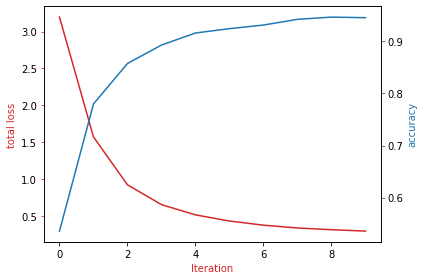

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
filename = 'model152.pt'

torch.save(model.state_dict(), filename)
! mv $filename drive/MyDrive/$filename
plot_stuff(loss_list, accuracy_list)

model = models.resnet152(pretrained=True)
model.fc = nn.Linear(n_neurons, n_classes)
model.load_state_dict(torch.load('drive/MyDrive/' + filename))
model.eval()